*PREGUNTA 4*

In [34]:
#import tot:
import random
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind, norm, ks_2samp
from statsmodels.stats.power import TTestIndPower

In [41]:
capsalera = [
    'order_id', 'activation_time_local', 'country_code', 'store_address', 'final_status', 'payment_status', 'products', 'products_total', 'purchase_total_price'
]
dataold = pd.read_csv('/Users/gabrielrogetdeaysa/Library/CloudStorage/GoogleDrive-rogetaysa@gmail.com/La meva unitat/IronhackGD/RepoIronhack/Project 3 - Ironhack Delivery/project_dataset/python_raw_data/fake_orders_test.csv', header= None, names= capsalera)
dataold.to_csv('/Users/gabrielrogetdeaysa/Library/CloudStorage/GoogleDrive-rogetaysa@gmail.com/La meva unitat/IronhackGD/RepoIronhack/Project 3 - Ironhack Delivery/project_dataset/python_raw_data/fake_orders_test_headers.csv',index=False)
data = pd.read_csv('/Users/gabrielrogetdeaysa/Library/CloudStorage/GoogleDrive-rogetaysa@gmail.com/La meva unitat/IronhackGD/RepoIronhack/Project 3 - Ironhack Delivery/project_dataset/python_raw_data/fake_orders_test_headers.csv')
data['activation_time_local'] = pd.to_datetime(data['activation_time_local'], errors='coerce', format='%d/%m/%Y %H:%M')
data.head()

,order_id,activation_time_local,country_code,store_address,final_status,payment_status,products,products_total,purchase_total_price
0,33557880,NaT,AR,14200,DeliveredStatus,PAID,1,4.54,8.64
1,33512615,NaT,TR,28725,DeliveredStatus,PAID,1,3.76,3.76
2,33512451,NaT,TR,28725,DeliveredStatus,PAID,1,2.86,2.86
3,33530892,NaT,ES,19777,CanceledStatus,PAID,1,12.95,0.00
4,33557765,NaT,AR,34565,DeliveredStatus,PAID,2,2.86,6.48


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60400 entries, 0 to 60399
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               60400 non-null  int64         
 1   activation_time_local  0 non-null      datetime64[ns]
 2   country_code           60400 non-null  object        
 3   store_address          60400 non-null  int64         
 4   final_status           60400 non-null  object        
 5   payment_status         60400 non-null  object        
 6   products               60400 non-null  int64         
 7   products_total         60400 non-null  float64       
 8   purchase_total_price   60400 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 4.1+ MB


In [43]:
data.describe()

,order_id,activation_time_local,store_address,products,products_total,purchase_total_price
count,6.040000e+04,0,60400.000000,60400.000000,60400.000000,60400.000000
mean,3.278265e+07,NaT,41580.723692,2.811358,9.832693,10.703447
min,3.150378e+07,NaT,190.000000,1.000000,0.000000,0.000000
25%,3.240091e+07,NaT,21110.000000,1.000000,4.110000,4.330000
50%,3.278110e+07,NaT,45849.000000,2.000000,7.120000,7.980000
75%,3.318279e+07,NaT,61992.250000,3.000000,12.750000,14.160000
max,3.356085e+07,NaT,75236.000000,39.000000,221.480000,265.760000
std,4.453627e+05,NaN,21905.784563,2.431214,9.276841,10.781632


In [44]:
# Generar lista de 100000 usuaris random fake
# Create the synthetic data for the ab testing example
# population_data = [random.randint(1, 100) for _ in range(population)]
population_data = data['products_total']

df = pd.DataFrame({'products_total':population_data})
df.head()

,products_total
0,4.54
1,3.76
2,2.86
3,12.95
4,2.86


In [45]:
# Initialize variables
contador = 0  # This will track the fraction of the dataset allocated to the test group
data = {}  # To store results

# Loop to calculate MDE for splits ranging from 5% to 50% of the dataset
while contador <= 0.45:
    contador += 0.05  # Increment the fraction for each iteration
    mde_list = []  # To store MDE values for each iteration
    avg_list = []  # To store average values for the control group
    
    # Perform 30 simulations for each split to average the MDE
    for i in range(1, 31):
        # Randomly split the dataset into test and control groups based on the current fraction
        test_df, control_df = train_test_split(df, test_size=contador)
        
        # Define the parameters for the MDE calculation
        alpha = 0.05  # Significance level
        beta = 0.8    # Desired statistical power
        
        # Calculate standard deviations for both groups
        std_dev_test = np.std(test_df['products_total'])
        std_dev_control = np.std(control_df['products_total'])
        
        # Calculate sample sizes
        sample_size_control = len(control_df)
        sample_size_test = len(test_df)
        
        # Calculate critical values for the two-tailed test
        z_alpha = norm.ppf(1 - alpha/2)
        z_beta = norm.ppf(beta)
        
        # Calculate pooled standard deviation
        pooled_std_dev = np.sqrt(((sample_size_control - 1) * std_dev_control**2 + 
                                  (sample_size_test - 1) * std_dev_test**2) / 
                                 (sample_size_control + sample_size_test - 2))
        
        # Calculate the MDE
        mde = (z_alpha + z_beta) * pooled_std_dev * np.sqrt(2 / sample_size_control)
        
        # Append the MDE and average control group price to their respective lists
        mde_list.append(mde)
        avg = np.mean(control_df['products_total'])
        avg_list.append(avg)
    
    # Calculate and store the average MDE, average price, and MDE percentage for the current split
    data[(round(contador, 2))] = {'mde': round(np.mean(mde_list), 4),
                                  'avg': round(np.mean(avg_list), 4),
                                  'mde_%': round(np.mean(mde_list) / np.mean(avg_list) * 100, 2)}

In [46]:
# Computed value for the sample selected
data

{0.05: {'mde': 0.6688, 'avg': 9.8033, 'mde_%': 6.82},
 0.1: {'mde': 0.4729, 'avg': 9.8158, 'mde_%': 4.82},
 0.15: {'mde': 0.3861, 'avg': 9.834, 'mde_%': 3.93},
 0.2: {'mde': 0.3344, 'avg': 9.8538, 'mde_%': 3.39},
 0.25: {'mde': 0.2991, 'avg': 9.8321, 'mde_%': 3.04},
 0.3: {'mde': 0.273, 'avg': 9.8193, 'mde_%': 2.78},
 0.35: {'mde': 0.2528, 'avg': 9.8379, 'mde_%': 2.57},
 0.4: {'mde': 0.2365, 'avg': 9.845, 'mde_%': 2.4},
 0.45: {'mde': 0.2229, 'avg': 9.8416, 'mde_%': 2.27},
 0.5: {'mde': 0.2115, 'avg': 9.8355, 'mde_%': 2.15}}

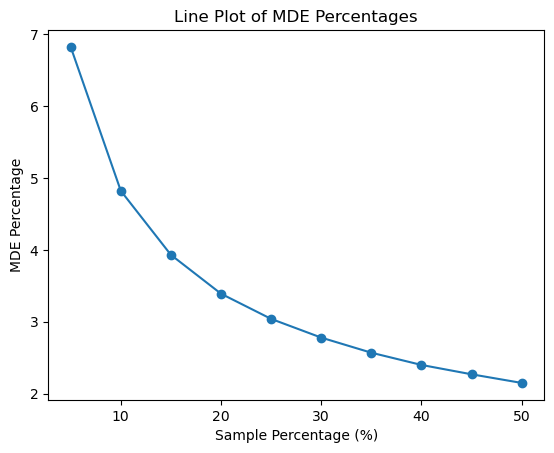

In [47]:
# Prepare data for plotting
percentage_split = [float(key)*100 for key in data.keys()]  # Convert keys to float and multiply by 100 to get percentages
mde_percentage_list_hist = [value['mde_%'] for value in data.values()]  # Extract MDE percentages

# Plotting
plt.plot(percentage_split, mde_percentage_list_hist, marker='o')  # 'o' adds markers to the line plot
plt.title('Line Plot of MDE Percentages')
plt.xlabel('Sample Percentage (%)')  # Updated to display counter percentage of the sample
plt.ylabel('MDE Percentage')

# Show the plot
plt.show()

In [49]:
# We run the split with 30% in test, as per the MDE curve we think it is the most optimal business<>statistical
test_df, control_df = train_test_split(df, test_size=0.3)


In [50]:
test_df

,products_total
16151,2.00
15425,6.25
28193,11.12
7105,4.15
32288,13.50
...,...
45443,13.90
52223,6.65
27711,11.53
11459,8.40


In [51]:
control_df

,products_total
3320,9.34
31493,4.92
35012,6.27
12494,3.47
22269,23.99
...,...
48697,3.19
57369,3.26
54204,2.79
56519,15.10


In [52]:
# Selecting the data from each DataFrame
# data1 = control_df['price']  # We select the column price from our df
# data2 = test_df['price']  # We select the column price from our df
data1 = control_df
data2 = test_df

# Perform the KS test
statistic, p_value = ks_2samp(data1, data2)

print(f"KS statistic: {statistic}")
print(f"P-value: {p_value}")

KS statistic: [0.0068275]
P-value: [0.59294475]


In [53]:
# Define the equivalence limits
low, upp = -0.2, 0.2 

# Unpacking the results
p_value_global, result_lower, result_upper = sm.stats.ttost_ind(data1, data2, low, upp)

# Print the results
print(f"Global p-value of TOST: {p_value_global}")
print(f"Inferiority test (difference > lower margin): Statistic = {result_lower[0]}, p-value = {result_lower[1]}")
print(f"Superiority test (difference < upper margin): Statistic = {result_upper[0]}, p-value = {result_upper[1]}")

# Interpretation based on p-values
if p_value_global < 0.05:
    print("There is enough statistical evidence to claim that the two group are equivalent within the specified equivalence margin.")
else:
    print("There is not enough evidence to claim that the two drugs are equivalent.")

Global p-value of TOST: [0.02784784]
Inferiority test (difference > lower margin): Statistic = [2.9426285], p-value = [0.00162781]
Superiority test (difference < upper margin): Statistic = [-1.91344618], p-value = [0.02784784]
There is enough statistical evidence to claim that the two group are equivalent within the specified equivalence margin.


### 1. ¿Qué porcentaje de pedidos están subautorizados?


In [14]:
data['subautorizado'] = data['products_total']<data['purchase_total_price'] 
porcentaje_subautorizado = data['subautorizado'].mean()*100
print(f"P1: % Subautorizados: {porcentaje_subautorizado:.2f}%")

P1: % Subautorizados: 57.58%


### 2. ¿Qué porcentaje de pedidos se autorizarían correctamente con una autorización incremental (+20%) sobre el monto en el checkout?

In [15]:
data['autorizacion_incremental']= data['products_total']*1.2 >= data['purchase_total_price']
percentatge_autoritzats_incremental = data['autorizacion_incremental'].mean()*100
print(f"P2: % de pedidos autoritzats amb increment de 20%: {percentatge_autoritzats_incremental:.2f}%")

P2: % de pedidos autoritzats amb increment de 20%: 69.03%


### 3. ¿Hay diferencias cuando se dividen por país?

In [20]:
por_pais = data.groupby('country_code')['autorizacion_incremental'].mean()*100
print("3: ")
por_pais

3: 


country_code
AR    66.388720
BR    50.000000
CI    66.666667
CL    12.952899
CR    79.855465
DO    62.000000
EC    62.599681
EG    65.645514
ES    71.497735
FR    67.322097
GE    68.315018
GT    79.717813
IT    70.085470
KE    73.404255
MA    77.512255
PA    66.929911
PE    78.098224
PR    87.878788
PT    63.916392
RO    72.173512
TR    68.887839
UA    72.663268
UY    79.473684
Name: autorizacion_incremental, dtype: float64

### 4. Para el resto de pedidos que quedarían fuera de la autorización incremental, ¿qué valores serían necesarios para capturar el monto restante?

In [22]:
sin_autorizacion_incremental = data.loc[data['subautorizado']& data['autorizacion_incremental'],'purchase_total_price']-data['products_total']
print("4: ")
display(sin_autorizacion_incremental)

4: 


0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
60395    0.16
60396     NaN
60397    0.67
60398     NaN
60399    0.44
Length: 60400, dtype: float64

In [33]:
def calcular_monto_extra(row):
    if row['subautorizado'] and not row['autorizacion_incremental']:
        if row['products_total'] == 0:
            return 10.00, row['purchase_total_price']
        else:
            pct_extra = (row['purchase_total_price'] / row['products_total']) - 1
            cantidad_extra = row['purchase_total_price'] - row['products_total']
            return pct_extra, cantidad_extra
    return 0, 0

data[['pct_monto_extra', 'cantidad_extra']] = data.apply(lambda row: pd.Series(calcular_monto_extra(row)), axis=1)

resultats = data[(data['pct_monto_extra'] != 0) | (data['cantidad_extra'] != 0)]

display(resultats[['products_total', 'purchase_total_price', 'pct_monto_extra', 'cantidad_extra']])

,products_total,purchase_total_price,pct_monto_extra,cantidad_extra
0,4.54,8.64,0.903084,4.10
4,2.86,6.48,1.265734,3.62
10,2.05,10.17,3.960976,8.12
12,8.10,10.20,0.259259,2.10
20,4.42,5.73,0.296380,1.31
...,...,...,...,...
60371,9.83,21.44,1.181078,11.61
60373,3.28,6.56,1.000000,3.28
60374,2.46,5.25,1.134146,2.79
60380,3.44,6.89,1.002907,3.45


### 5. ¿Qué tiendas son las más problemáticas en términos de pedidos y valor monetario?

In [6]:
problematicas = data.groupby('store_address').agg({'subautorizado':'sum','purchase_total_price':'sum'}).sort_values(by='subautorizado',ascending=False)
print("5: ")
print(problematicas.head())

5: 
               subautorizado  purchase_total_price
store_address                                     
28671                    448               4714.97
28712                    217               3781.39
28286                    204               1246.12
14455                    179               3514.33
11694                    160               1065.96


### 6. Para los pedidos subautorizados, ¿hay una correlación entre la diferencia en los precios y la cancelación del pedido? En otras palabras: ¿Es más probable que se cancele un pedido a medida que aumenta la diferencia de precio?

In [7]:
data['diferencia_preu']=data['purchase_total_price']-data['products_total']
correlacio = data['diferencia_preu'].corr(data['final_status'].apply(lambda x:1 if x == 'CanceledStatus' else 0))
print(f"6: Correlacio {correlacio:.2f}")

6: Correlacio -0.43
